<a href="https://colab.research.google.com/github/ValKhv/AMNEZIA-2/blob/main/Mondrian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MONDRIAN $k$-ANONIMISATION ALGORITHM

-------------------
<font size="2">Текущая версия ноутбука Jupiter представляет собой адаптацию версиии [Nuclearstar/K-anonymity](https://github.com/Nuclearstar/K-Anonymity) для GOOGLE COLAB. Основные функции представлены на Python 3 с использованием структур  `pandas` и средств визуализации `matplotlib`)</font>

$\qquad$ В данном ноутбуке исследуются несколько алгоритмов "k-anonymity" 

Расчет выполняется аналогично вычислениям AMNEZIA на основании кластеризации одинаковых строк (классов эквивлентности) для расчета и обсепечения анонимизации исходного набора данных.

Для большей информации смотрите: 

- [Модель расчета риска: презентация АБД](https://app.box.com/s/r59vlvmonzpsu1xi46tk8wn1svt39h2o)
- [Рекомендации по методам обезличивания: рабочая версия АБД](https://app.box.com/s/hvgwq7py6b59slpkalu9fzidvppib8rd)
- [k-Anonymity: A Model For Protecting Privacy. Latanya Sweeney](https://epic.org/privacy/reidentification/Sweeney_Article.pdf)
- [Mondrian - Multidimensional k-Anonymity](https://www.utdallas.edu/~muratk/courses/privacy08f_files/MultiDim.pdf)

## 1 ВВЕДЕНИЕ

## 1.1 Основные понятия

#### 1.1.1 Модель $k$-anonimity и риски повторной идентификации
<p align="justify">$\qquad$ <b>k-anonymity</b> -модель, которая позволяет снижать риски повторной идентификации путем объединения атрибутов в группы, описывающие не менее $k$ людей. Предположим, что имеется набор из  $N$ строк/записей. Каждая запись состоит из  $D$ полей/атрибутов, из которых $X_i$ ($i \in [0,D]$) не содержат конфиденциальной информации (non-sensitive) о физическом лице, примером таких атрибутов является возраст, пол, почтовый код и т.п. Однако,  это подмножество атрибутов может в совокупности указывать на конкретное лицо в данной группе.Такие атрибуты, в совокупности указывающие на конкретную персону называются <b>квази-идентификаторами</b> ("quasi-identifiers"), а их комбинация - <b>супер-идентификатор</b> ("super-identifier"), который может указывать на уникальную персону в достаточно большом наборе данных (т.е. комбинация пола, возраста и почтового кода ведет к выделению отдельной личности). </p>
     
<p align="justify">$\qquad$ В дополнение подразумевается, что кроме квази-идентификаторов набор данных может содержать некоторые данные напрямую указывающие на личность (например, ИНН) - <b>прямые идентификаторы</b> ("direct-identificatotrs"), а также по крайней мере один атрибут представляющий чувствительную информацию - например, уровень дохода ("income") или сведения о болезни. Модель нацелена на защиту этой чувствительной информации. В рамках такой защиты записи подвергаются методам обезличивания - <b>обобщению</b> ("generalization") или подавлению ("suppression"), цель этих методов разрушить информацию таким образом, чтобы снизить количество строк с одинаковыми квази-атрибутами (так называемые классы эквивалентности). Объем минимального класса эквивалентности (количество записей с одинаковыми занчениями квази-идентификаторов) обратно пропорционален вероятности риска повторной идентификации и может служить числовой характеристикой метода.</p> 


<p align="justify">$\qquad$ Применение методов обезличивания ведет к тому, что полезная информация в обезличенных наборах данных становится менеее качественной - для измерения уровня этого качества используются специальные метрики <b>расчета полезности</b> ("utility"). Суть модели - нахождение баланса между риском повторной идентификации с одной стороны и полезностью набора  данных - с другой.</p>

<p align="justify">$\qquad$ В первом приближении модель k-anonymity  требует выделения квази-идентификаторов ("QID") и вычисления для них <b>размеров классов-эквивалентности</b>  $k$ строк/физических лиц, затем итерационное применение методов обезличивания (включающих подавление строк или ячеек, обобщение значений), между которыми следует анализ получившегося набора и уточнение параметров методов обезличивания. В результате это защищает отдельных людей, сводя к минимому информацию об отдельном человеке, оставляя злоумышленнику ("adversary") только информацию о принадлежности данного человека к определенной группе.  Хотя получающийся набор не является точным, он все еще годится для целей анализа и построения моделей машинного обучения. В ряде случаев надо решать не только проблему обезличивания, но и иного подхода к идентификации, например, для решения задач, в которых обобщенные данные не могут использоваться напрямую.</p>

#### 1.1.2 Расширение модели через метрику $l$-разнообразие

<p align="justify">$\qquad$ Одной из проблем применения модели "k-anonimity" является возможная особенность данных, при которой все строки в одинаковой группе по квази-идентификатором (все записи класса эквивалентности) содержат одинаковое значение чувствительного атрибута.  Тогда, злоумышленник, который знает, что человек находится в данной группе - может получить информацию о чувствительном атрибуте в данной группе. Эта проблема может быть решена за счет  расширения "k-fnonimity" применением метрики с названием  <b>$l$-разнообразие</b> "$l$-diversity": такая метрика гарантирует, что каждый класс эквивалентности (по k-anonymity) сдержит по крайней мере $l$ различных значений чувствительного атрибута. В этом случае злоумышленник даже в случае определения группы человека (например, исходя из информации вне данного контекста, скажем имея какие-то внешние сведения) - все равно не сможет уверенно определить значение чувствительного атрибута этого человека. </p>

#### 1.1.3 Дальнейшие расширения с использованием метрик $t$-близости

<p align="justify">$\qquad$ Даже такая улучшенная на основании $l$-разнообразнообразия модель все еще не может гарантировать полной защиты: злоумышенник может получить информацию о чувствительном атрибуте исходя из веростностных оценок внутри класса эквивалентности (напреимр, 4/5 класса обладает данным атрибутом, следовательно, человек принадлежащий данной групе/классу c вероятностью 80% обладает данным атрибутом). Для преодоления этого ограничения вводится понятие критерия <b>$t$-близости</b> ($t$-closeness):  такой критерий требует, чтобы статистическое распределение атрибутов в каждом классе эквивалентности было "близко" к общему распределению во всем наборе данных.  Метрику $t$-closeness можно измерить с использованием, например, дивергенции <i>Кульбака-Лейблера</i> (<i>Kullback-Leibler divergence, KL</i>). В этом случае злоумышленник может получить ограниченный набор информации, сравнивая распределение значений в группе с распределением во всем наборе данных.</p>

<p align="justify">$\qquad$ Конечно, $k$-анонимность, $l$-разнообразие и $t$-близость ограничивают объем информации, которую законный пользователь также может извлечь из данных, поэтому, как правило, нам необходимо <b>сбалансировать степень конфиденциальности с полезностью полученных данных</b>. Кроме того, различный <b>уровень риска</b> ("risk treshlod"), определяемый из преобразования для одних случаев использования является приемлемым, для  других - нет.</p>


### 1.2 Алгоритм Мондриана для расчета k-anonymity

<p align="justify">$\qquad$ Процесс обезличивания, в общих терминах описываемый выше при достижении $k$- anonimity (и, возможно, $l$-diversity или $t$-близости, является сложной вычислительной задачей (<b>NP-hard problem</b>). В тоже время существет несколько практических алгоритмов, дающих приемлемые результаты ("good enough"), например, с использованием так называемого "жадного" поиска (#"greedy search techniques"). </p>

<p align="justify">Одним из возможных методов является <b>алгоритм Мондриана</b> ("Mondrian" algorithm, название вытекает из 2D представления групп, напоминаюших картины Пита Мондриана - Piet Mondrian).</p>
<p align="justify">$\qquad$ Алгоритм Мондриана - метод анонимизации данных сверху вниз, предложенный Кристеном Лефевром в 2006 году, относится к жадным (greedy) алгоритмам. В рамках этого метода категориальные данные преобразуются в числовые и применяются иерархии обобщения (в строгом случае это называется <i>Basic_Mondrian</i>)</p>


<p align="justify">Для применения алгоритма все атрибуты должны быть преобразованы в числовые или категориальные значения, так что мы можем измерить диапазон ("span") заданного атрибуа данных  $X_i$.</p>

#### 1.2.1 Базовая идея алгоритма

<p align="justify">$\qquad$ Предполагаем, что мы имеем набор данных, организованный в виде строк и столбцов (атрибутов), которые можно представить в виде $[QID, SA]$. Здесь $QID$ _ квази-идентификаторы, а $SA$ - чувствительные атрибуты (<i>Sensitive Attributes</i>). Первоначальная информация организована так, что каждому $QID$ соответсвует свой $SA$ и легко с помощью этих квазиидентификаторов можно повторно идентифицировать  физическое лицо и соотнести его с чувствительной (конфиденциальной) информацией. Однако, если появляется возможность разбить исходный набор на кластеры (партиции, кластеры), так что квази-идентификаторы совпадают и образуют единую группу $QID^*$, которой соответсвуют несколько $SA$, то соотнести конкретный $SA$ с исходным $QID$ не предоставляется возможности.</p>


<img src="http://intelligentobjectsio.ipage.com/dgtworld/images/AnonimizedDataSet_4.png" style="height:10px">QID кластеризация</img>

<p align="justify">$\qquad$ На практике необработанные (не обезличенные) наборы данных не обладают свойством $k$- anonimity, при котором одному обобщенному $QUID^*$ соответсвует несколько $SA_i$</p>
<p align="justify">$\qquad$ В связи с этим исходный набор подвергается обработке:</p>
<li> <b>PARTITION</b>: Исходный набор делится на k-группы (каждая содержит не менее k-записей), используя $kd$-дерево так, чтобы группа имела схожие $QID_i$;</li>
<li> <b>GENERALIZATION:</b> группа обобщается таким образом, чтобы каждая запись имела одинаковый $QID^*$</li>

<p align="justify">$\qquad$  $kd$-дерево - специальная геометрическая структура данных, позволяющая разбить пространство на "меньшие части" посредством сечения плоскостями ($K=3$), прямыми ($K=2$)</p>

<img src="https://cloud.githubusercontent.com/assets/3848789/25949052/c6ab3fce-3688-11e7-99ea-cde7bccd8684.png">$kd$-tree</img>



#### 1.2.2 Иерархии обобщения
<p align="justify">$\qquad$ Иерархии обобщения (<i>Generalization Hierarchies</i>) - концепция, предполагающая, что числовых или категориальных данных, для которых диапазон данных не имеет смысла (например, данные пола [Male-Female] или справочник заболеваний ICD09 [200-210]) вводятся предопределенные иерархии обобщения. </p>
<img src="http://intelligentobjectsio.ipage.com/dgtworld/images/GeneHierarch.png" style="height:10px">Иерархии обобщения</img>


### 1.3 Парционирование (выделение групп/классов эквивалентности)

<p align="justify">$\qquad$ Для разделения данных на k-anonymous групп алгоритм требует выполнения следующих шагов (напоминающих метод половинного деления):</p>

>  
1. Инициализируем конечный массив  групп/классов эквивалентности (изначально пустых) $P_{finished} = \{\}$.
2. Инициализируем рабочий массив, который содержит единственную группу - весь набор данных $P_{working} = \{\{1, 2,\dots ,N\}\}$.
3. Выполняем цикл: пока в рабочем наборе есть хоть одна группа (partition) - извлекаем ее и выполняем следующие действия:
  * Вычисляем относительные частоты (spans) для всех атрибутов - столбцов в выделенной группе.
  * Сортируем плученные столбцы по их частоте в порядке убывания и выполняем итерацию для каждого столбца:
      * Разбиваем полученную группу - по каждому столбцу, используя медиану в качестве точки разделения ("split point").
      * Проверяем, соответсвуют ли полученные данные критериям k-анонимизации (или иным критериям)- в том числе с оценкой вероятности повторной идентификации.
      * Если да, то добавляем в массив групп два овых набора и выходим из цикла. Если нет - проводим дальнейшие преобразования.
  * Если ни по одному из столбцов не получилось корректно разделить набор - добавляем такой набор в массив конечных наборов.
4. Возвращаем набор конечны групп
>

### 1.4 Методы обезличивания: обобщение (Data Generalization/Aggregation)

<p align="justify">$\qquad$ Процесс получения  необходимых значений критериев анонимности - итерационный. Для его выполнения на каждом шаге производится собственно обезличивание. Самый распространенный классический метод - обобщение ("generalization"). Для числовых атрибутов, например, можно заменить их точные значения диапазоном (скажем для возраста 26 - диапазоном: 24-28), категориальные атрибуты - их объединением, например, цвет глаз (серый, зеленый, голуюой, карий, черный) &rarr; (СВЕТЛЫЕ;ТЕМНЫЕ). 
Методы анатомизации  <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.156.9150&rep=rep1&type=pdf">Anatomy</a> могут разбивать каждую группу на отдельные микро-кластеры, хотя их необдуманное использование повышает общий риск повторной идентификации. </p>

### 1.5 Использование обезличенных данных 

$\qquad$ После получения обезличенных данных требуется оценить их полезность и пригодность для машинного обучения (например, scikit-learn). Методы оценки полезности рассматриваются отдельно.

## 2 РАСЧЕТ С ИСПОЛЬЗОВАНИЕМ $k$-Anonymity
$\qquad$ Ниже предлагается применение метода к определенному набору!

### 2.1 Подготовка к расчетам - загрузка данных


In [1]:
# Для выполнения расчетов изпользуем библиотека Pandas, облегчающая работу с категориальными данными
import pandas as pd
# Для версии Colab используем Google Drive вместо локальной ссылки на данные

PATH_TO_DATA = "data/marketing_case_v.0.3.2.xlsx"  # Используйте для локальной версии
SHEET_A3 = "A3"

In [2]:
# Массив атрибутов/столбцов, поскольку файл данных не содержит заголовка (as the file doesn't contain any headers)
names = (
       'ID Микросегмент',
    'Локальное время покупок',
    'Код региона',
    'Часовой пояс',
    'Кол-во покупок',
    
    'Бренды',
    'Категория'
)

# Выделим дополнительно категориальные данные (C-Data) из представленных выше атрибутов
categorical = set((
       'ID Микросегмент',
    'Локальное время покупок',
    'Код региона',
    'Часовой пояс',
    'Кол-во покупок',
  
    'Бренды',
    'Категория'
))
df = pd.read_excel(PATH_TO_DATA, sheet_name=SHEET_A3,nrows=6000);# Загружаем основной набор данных

In [3]:
df.head(2)

,ID Микросегмент,Локальное время покупок,Код региона,Часовой пояс,Кол-во покупок,Кол-во товаров в покупоке,Бренды,Категория
0,1,2020-02-25T06:32+00:03,38,UTC+5,2,2,Lenovo,Монитор
1,2,2020-01-08T17:27+00:03,38,UTC+5,2,2,Aerocool,Системы охлаждения


In [4]:
for name in categorical:
    df[name] = df[name].astype('category')

### 2.2 Вспомогательные функции

#### 2.2.1 Расчет диапазонов значений атрибутов

<p align="justify">$\qquad$ Имплементация функции, которая  дает <b>диапазоны изменения</b> (spans) для всех атрибутов/столбцов набора -dataframe (max-min для числовых атрибутов, число различных значений для категориальных данных).</p> 

In [5]:
def get_spans(df, partition, scale=None):
    """
    :param        df: дата-фрейм, для которого рассчитывается диапазон
    :param partition: группа/класс эквивалентности для которого рассчитывается диапазон (spans)
    :param     scale: масштаб парционирования для каждого столбца
                      (может отсутсвовать)
    :        returns: диапазоны (spans) для каждого изменения
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [6]:
full_spans = get_spans(df, df.index)
full_spans

{'ID Микросегмент': 6000,
 'Локальное время покупок': 5809,
 'Код региона': 1,
 'Часовой пояс': 1,
 'Кол-во покупок': 5,
 'Кол-во  товаров в покупоке': 4,
 'Бренды': 231,
 'Категория': 26}

#### 2.2.2 Функция Split

<p align="justify"> $\qquad$ Функция 'split' принимает dataframe, столбец и исходную группу/раздел - возвращает пару разделов, которые образуются медианой на данном разделе</p>

In [7]:
def split(df, partition, column):
    """
    :param        df: Исходный dataframe
    :param partition: Исходный раздел (partition), который пробуем разбить
    :param    column: Определенный столбец, который определяет границы разбиения
    :        returns: Возвращаем кортеж с разделением исходного раздела (два раздела)
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

### 2.3 Реализация k-anonimity

In [8]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: Входной набор для которого осуществляется парционирование.
    :param        partition: Выделенная группа.
    :param sensitive_column: Наименование "чувствительного" атрибута/столбца
    :param                k: Уровень требуемого k-anonimity
    :returns               : Возвращает True если разбиение на партиции соответсвует k-anonimity, False - если достичь нужного уровня не удается.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: Набор для парционирования.
    :param  feature_columns: Список столбцов, по которым осуществляем парционирование внутри набора.
    :param sensitive_column: Наименование чувствительного атрибута, для которого определяем партицию -`is_valid` функция)
    :param            scale: Параметр парционирования для заданного столбца.
    :param         is_valid: Функция проверки партиции для заданного набора - возвращает True, если партиция корректна и False, если это не так.
    :returns               : Возвращает список годных партиций, покрывающих весь набор (dataframe).
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions


#### 2.3.1 Дизайн алгоритма Мондриана (парционирования)
$\qquad$ Применяем определенные ранее (см. 4.2) вспомогательные функции для разбиения на классы эквивалентности с использованием метрик $k$-Anonimity:

#### 2.3.2 Применение метода расчета к набору данных

<p align="justify"> $\qquad$Применение определенных выше функций к набору данных позволяет сформировать обезличенный набор. В целях упрощения ограничимся только двумя столбца для парционирования (простое применение алгоритма для полного набора может взять нескоько минут для полного набора) </p>

In [9]:
# В рамках текущей реализации используются два квази-идентификатора (feature_columns) и всего один чувствительный атрибут "income"
feature_columns = ['Локальное время покупок','Категория','Бренды']
sensitive_column = 'Кол-во покупок'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [10]:
# в результате получаем число классов эквивалентности, созданных на наборе с заданным k = 3 we get the number of partitions that were created
len(finished_partitions)

1577

### 2.4 Визуализация парционирования

<p align="justify"> $\qquad$ Визуализация (с помощью matplotlib) парционирования может быть через определение прямоугольных  границ раздела по двум столбцам. Ожидаемый эффект - прямоугольники не перекрываются и покрывают весь набор<p>

In [11]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [12]:
# Расчет индексов
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

# Расчет координат
def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # добавим небольшой сдвиг для улучшения представления
    l -= offset
    r += offset
    return l, r

# Расчет прямоугольников для соответсвующих классов эквивалентности
def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

# Получение границ с учетом сдвигов
def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [13]:
# Собственно расчеты для всех созданных партиций (классов эквивалентности)
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [14]:
# Каждый прямоугольник представлен своими границами, нанесенными на общий прямоугольник исходного набора. Вот некоорые из них:
rects[:10]

[((1563.0, 11.0), (5592.0, 26.0)),
 ((172.0, 22.0), (4884.0, 23.0)),
 ((682.0, 7.0), (5524.0, 8.0)),
 ((2479.0, 11.0), (5637.0, 12.0)),
 ((1148.0, 14.0), (5077.0, 15.0)),
 ((634.0, 0.0), (4872.0, 26.0)),
 ((5.0, 0.0), (2793.0, 15.0)),
 ((66.0, 14.0), (4619.0, 15.0)),
 ((1884.0, 3.0), (5244.0, 4.0)),
 ((1212.0, 3.0), (4377.0, 16.0))]

In [15]:
# Далее строим график
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

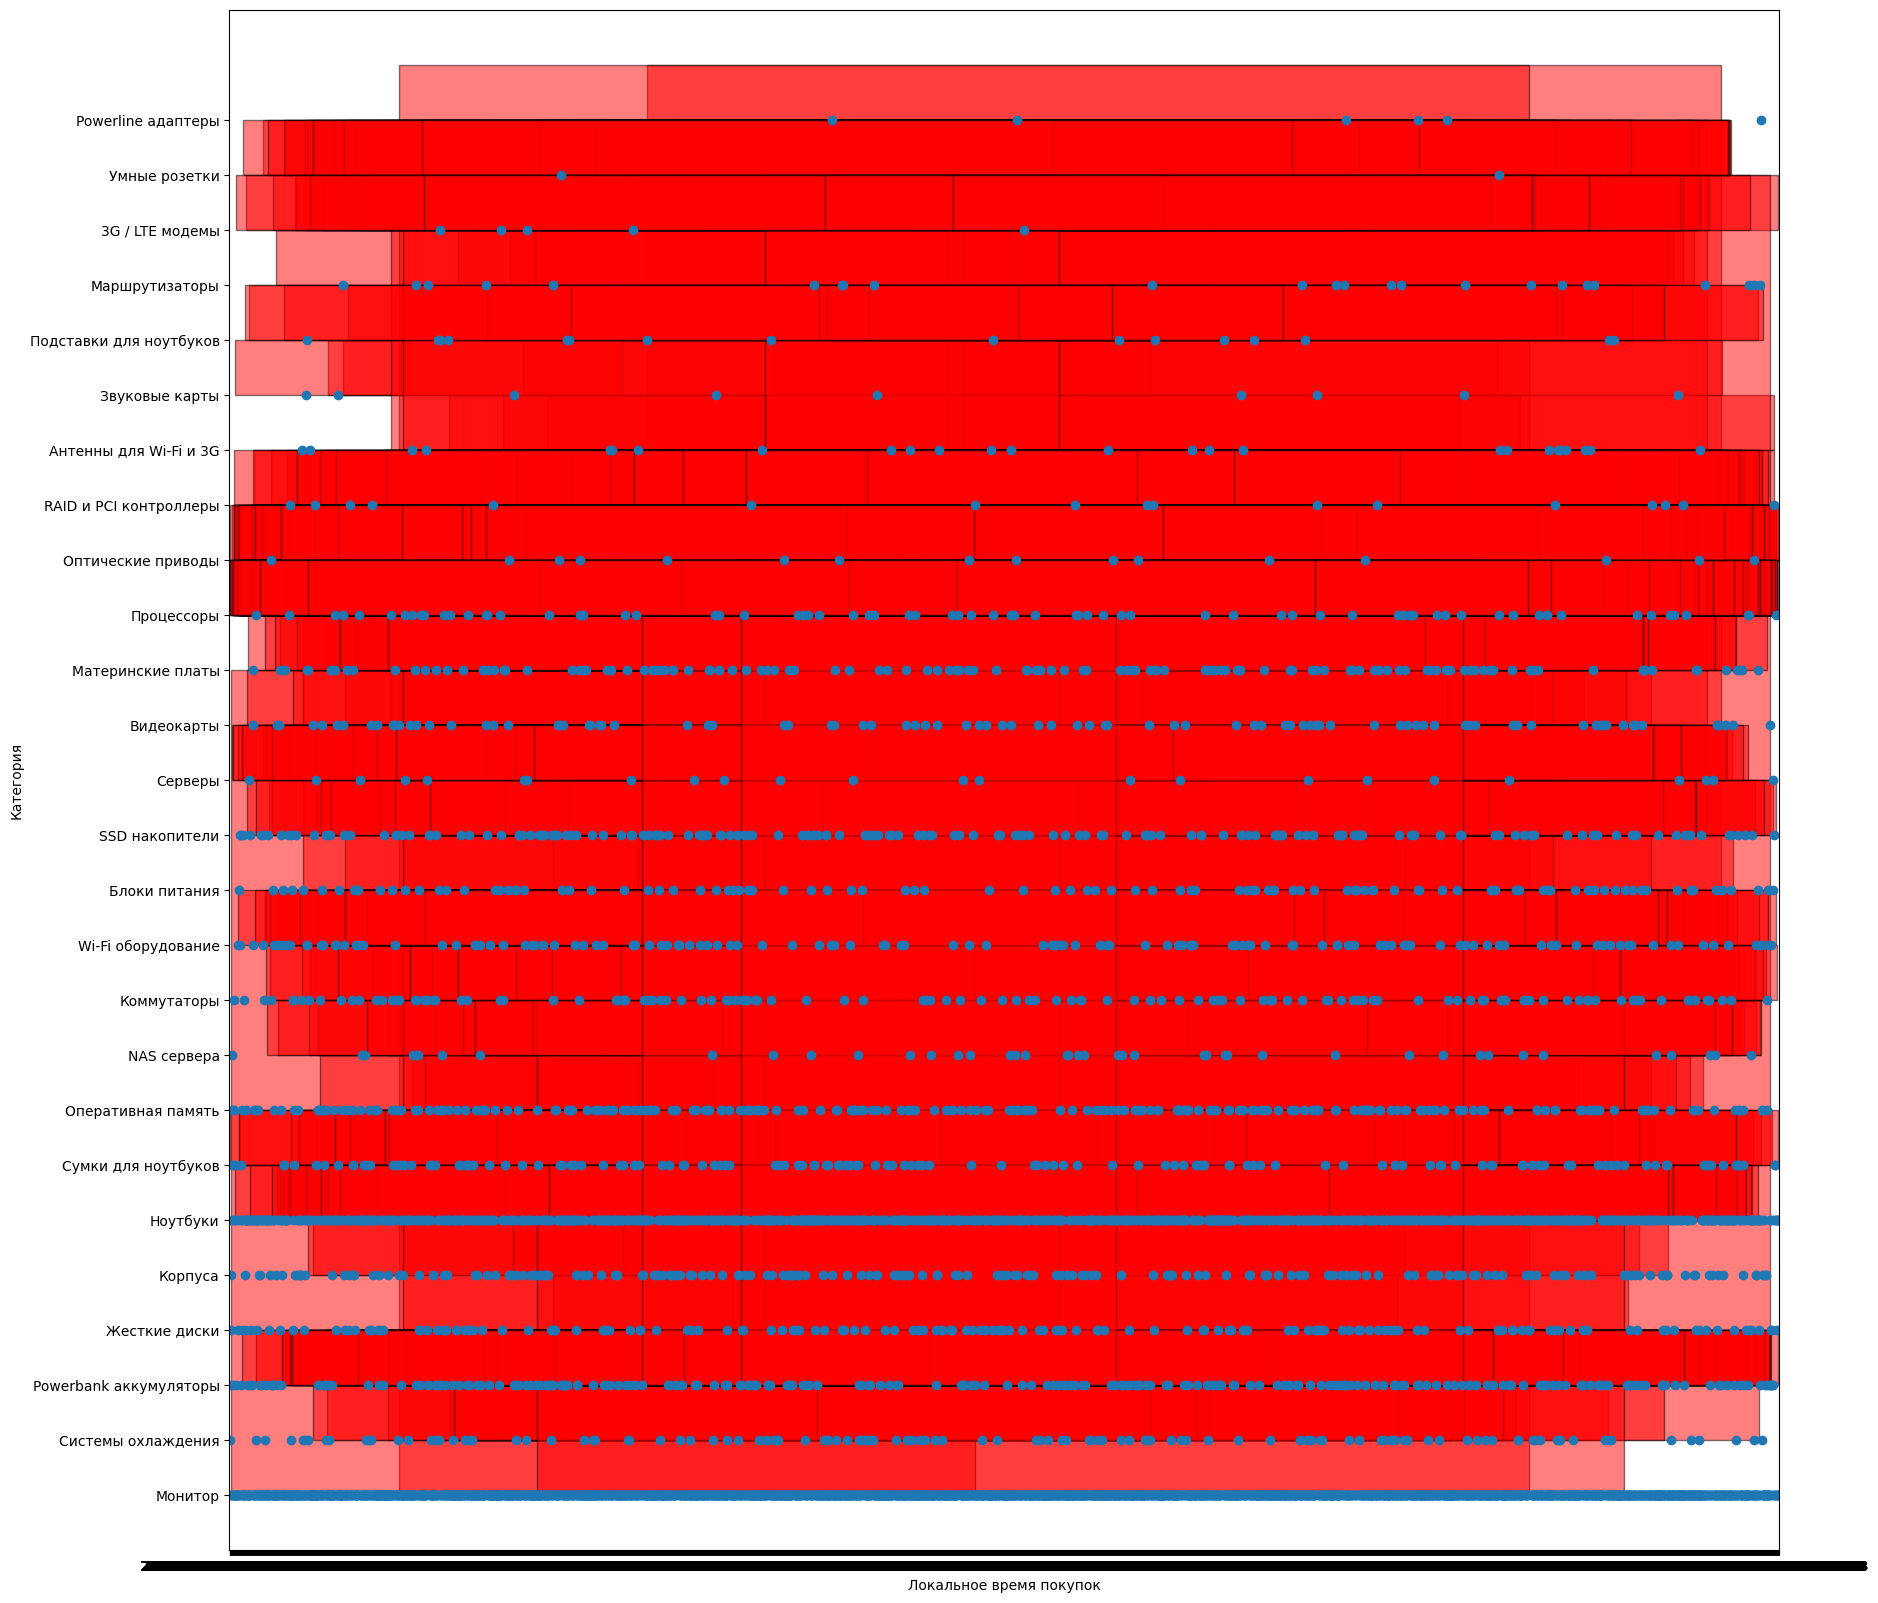

In [16]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

### 2.5 Generating an k-Anonymous Dataset

В процессе обезличивания мы создаем новый набор данных, который содержит для каждого каласса эквивалентности - отдельную строку с представлением чувствительного атрибута

#### 2.5.1 Дизайн расчетных функций
Определяем вспомогательные функции для аггрегации категориальных данных и числовых данных, а также собственно  функцию построения нового набора данных

In [17]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [18]:
# Python3 program to Convert a
# list to dictionary
 
def ListConvert(lst):
    it = iter(lst)
    res_dct = dict(zip(it, it))
    return res_dct

In [19]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.to_dict() #grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

#### 2.5.2 Проведение расчетов и сохранение результатов

Применяем определенные выше функций, которые осуществляют собственно анонимизацию 

In [20]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...
Finished 601 partitions...
Finished 701 partitions...
Finished 801 partitions...
Finished 901 partitions...
Finished 1001 partitions...
Finished 1101 partitions...
Finished 1201 partitions...
Finished 1301 partitions...
Finished 1401 partitions...
Finished 1501 partitions...


In [21]:
# Рассматриваем полученные данные после их агрегации
dfn.head

<bound method NDFrame.head of                                 Локальное время покупок  \
0     [2020-01-19T21:07+00:03,2020-03-08T00:08+00:03...   
1     [2020-01-19T21:07+00:03,2020-03-08T00:08+00:03...   
2     [2020-01-26T14:43+00:03,2020-01-26T06:33+00:03...   
3     [2020-01-26T14:43+00:03,2020-01-26T06:33+00:03...   
4     [2020-01-26T14:43+00:03,2020-01-26T06:33+00:03...   
...                                                 ...   
4444  [2020-02-13T20:09+00:03,2020-02-20T03:04+00:03...   
4445  [2020-02-13T20:09+00:03,2020-02-20T03:04+00:03...   
4446  [2020-02-13T20:09+00:03,2020-02-20T03:04+00:03...   
4447  [2020-02-08T14:38+00:03,2020-02-18T17:22+00:03...   
4448  [2020-02-08T14:38+00:03,2020-02-18T17:22+00:03...   

                           Категория                       Бренды  \
0     [Умные розетки,Звуковые карты]            [Asus,Elgato,RME]   
1     [Умные розетки,Звуковые карты]            [Asus,Elgato,RME]   
2                          [Серверы]  [Hewlett Packard

In [22]:
# сортируем полученный результат по чувствительным атрибутам (income)
dfn.sort_values([sensitive_column])

,Локальное время покупок,Категория,Бренды,Кол-во покупок,count
0,"[2020-01-19T21:07+00:03,2020-03-08T00:08+00:03...","[Умные розетки,Звуковые карты]","[Asus,Elgato,RME]",1,4
1200,"[2020-02-05T04:29+00:03,2020-02-05T11:21+00:03...",[Процессоры],[Intel],1,1
3234,"[2020-02-08T00:50+00:03,2020-03-06T06:17+00:03...",[Монитор],[Iiyama],1,2
1194,"[2020-02-09T04:52+00:03,2020-01-27T22:18+00:03...",[Процессоры],[Intel],1,1
3237,"[2020-01-22T22:23+00:03,2020-02-02T09:57+00:03...",[Монитор],[Iiyama],1,1
...,...,...,...,...,...
3277,"[2020-02-06T11:54+00:03,2020-01-21T06:21+00:03...",[Монитор],[NEC],5,2
3275,"[2020-01-12T01:38+00:03,2020-02-24T13:30+00:03...",[Монитор],[NEC],5,1
1150,"[2020-01-19T19:06+00:03,2020-01-31T10:20+00:03...",[Оперативная память],[AMD],5,1
1134,"[2020-01-04T16:59+00:03,2020-03-06T03:36+00:03...",[Жесткие диски],[Toshiba],5,1


In [23]:
# Сохраняем набор
dfn.to_csv('anonimimized.csv')

# 3 РАСЧЕТ НА ОСНОВЕ $l$-DIVERSITY

<p align="justify"> $\qquad$ Рассматривается упрощенный алгоритм. $l$-разнообразие позволяет значительно улучшить конфиденциальность, как это было описано в 1.1 и представляет собой расширение метрики k-anonimity. Для внедрения расчетов $l$-diversity в уже реализованную модель (2.3 - 2.5) необходимо:</p>

* Модифицировать функцию  `is_valid` так, чтобы кроме проверки размера партиции (группы/класса эквивалентности) осуществлялся контроль распределения чувствительного атрибута внутри каждой группы.
* Модифицировать функцию  `split` для разделения группы с учетом диверсификации чувствительного атрибута (при наличии такой возможности)

### 3.1 Валидация $l$-diversity

**Новая функция валидатора возвращает `True`, если выбранная группа содержит, по крайней мере `l`  различное значение чувствительного атрибута, в противоположном случае - `False`.**

In [24]:
def diversity(df, partition, column):
    return len(df[column][partition].unique())

def is_l_diverse(df, partition, sensitive_column, l=2):
    """
    :param               df: набор данных, предназначенный для возвращения  l-diversity
    :param        partition: выделенная группа для проверки  l-diversity
    :param sensitive_column: наименование стобца- чувствительного атрибута
    :param                l: минимальная граница требуемой диверсификации чувствительного атрибута
    """
    return diversity(df, partition, sensitive_column) >= l

### 3.2 Кластеризация по $l$-diversity

In [25]:
# применяем новую функцию для парционирования данных, заменяя при вызовые partition_dataset функцию [is_k_anonimous] на сочетание с [is_l_diverse]  
finished_l_diverse_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_l_diverse(*args))

In [26]:
len(finished_l_diverse_partitions)

1550

Рассчитаем новые прямоугольники-кластеры данных соответствующие новым классам эквивалентности с испоользованием определенной в 2.4 функции `get_partition_rects`

In [27]:
column_x, column_y = feature_columns[:2]
l_diverse_rects = get_partition_rects(df, finished_l_diverse_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

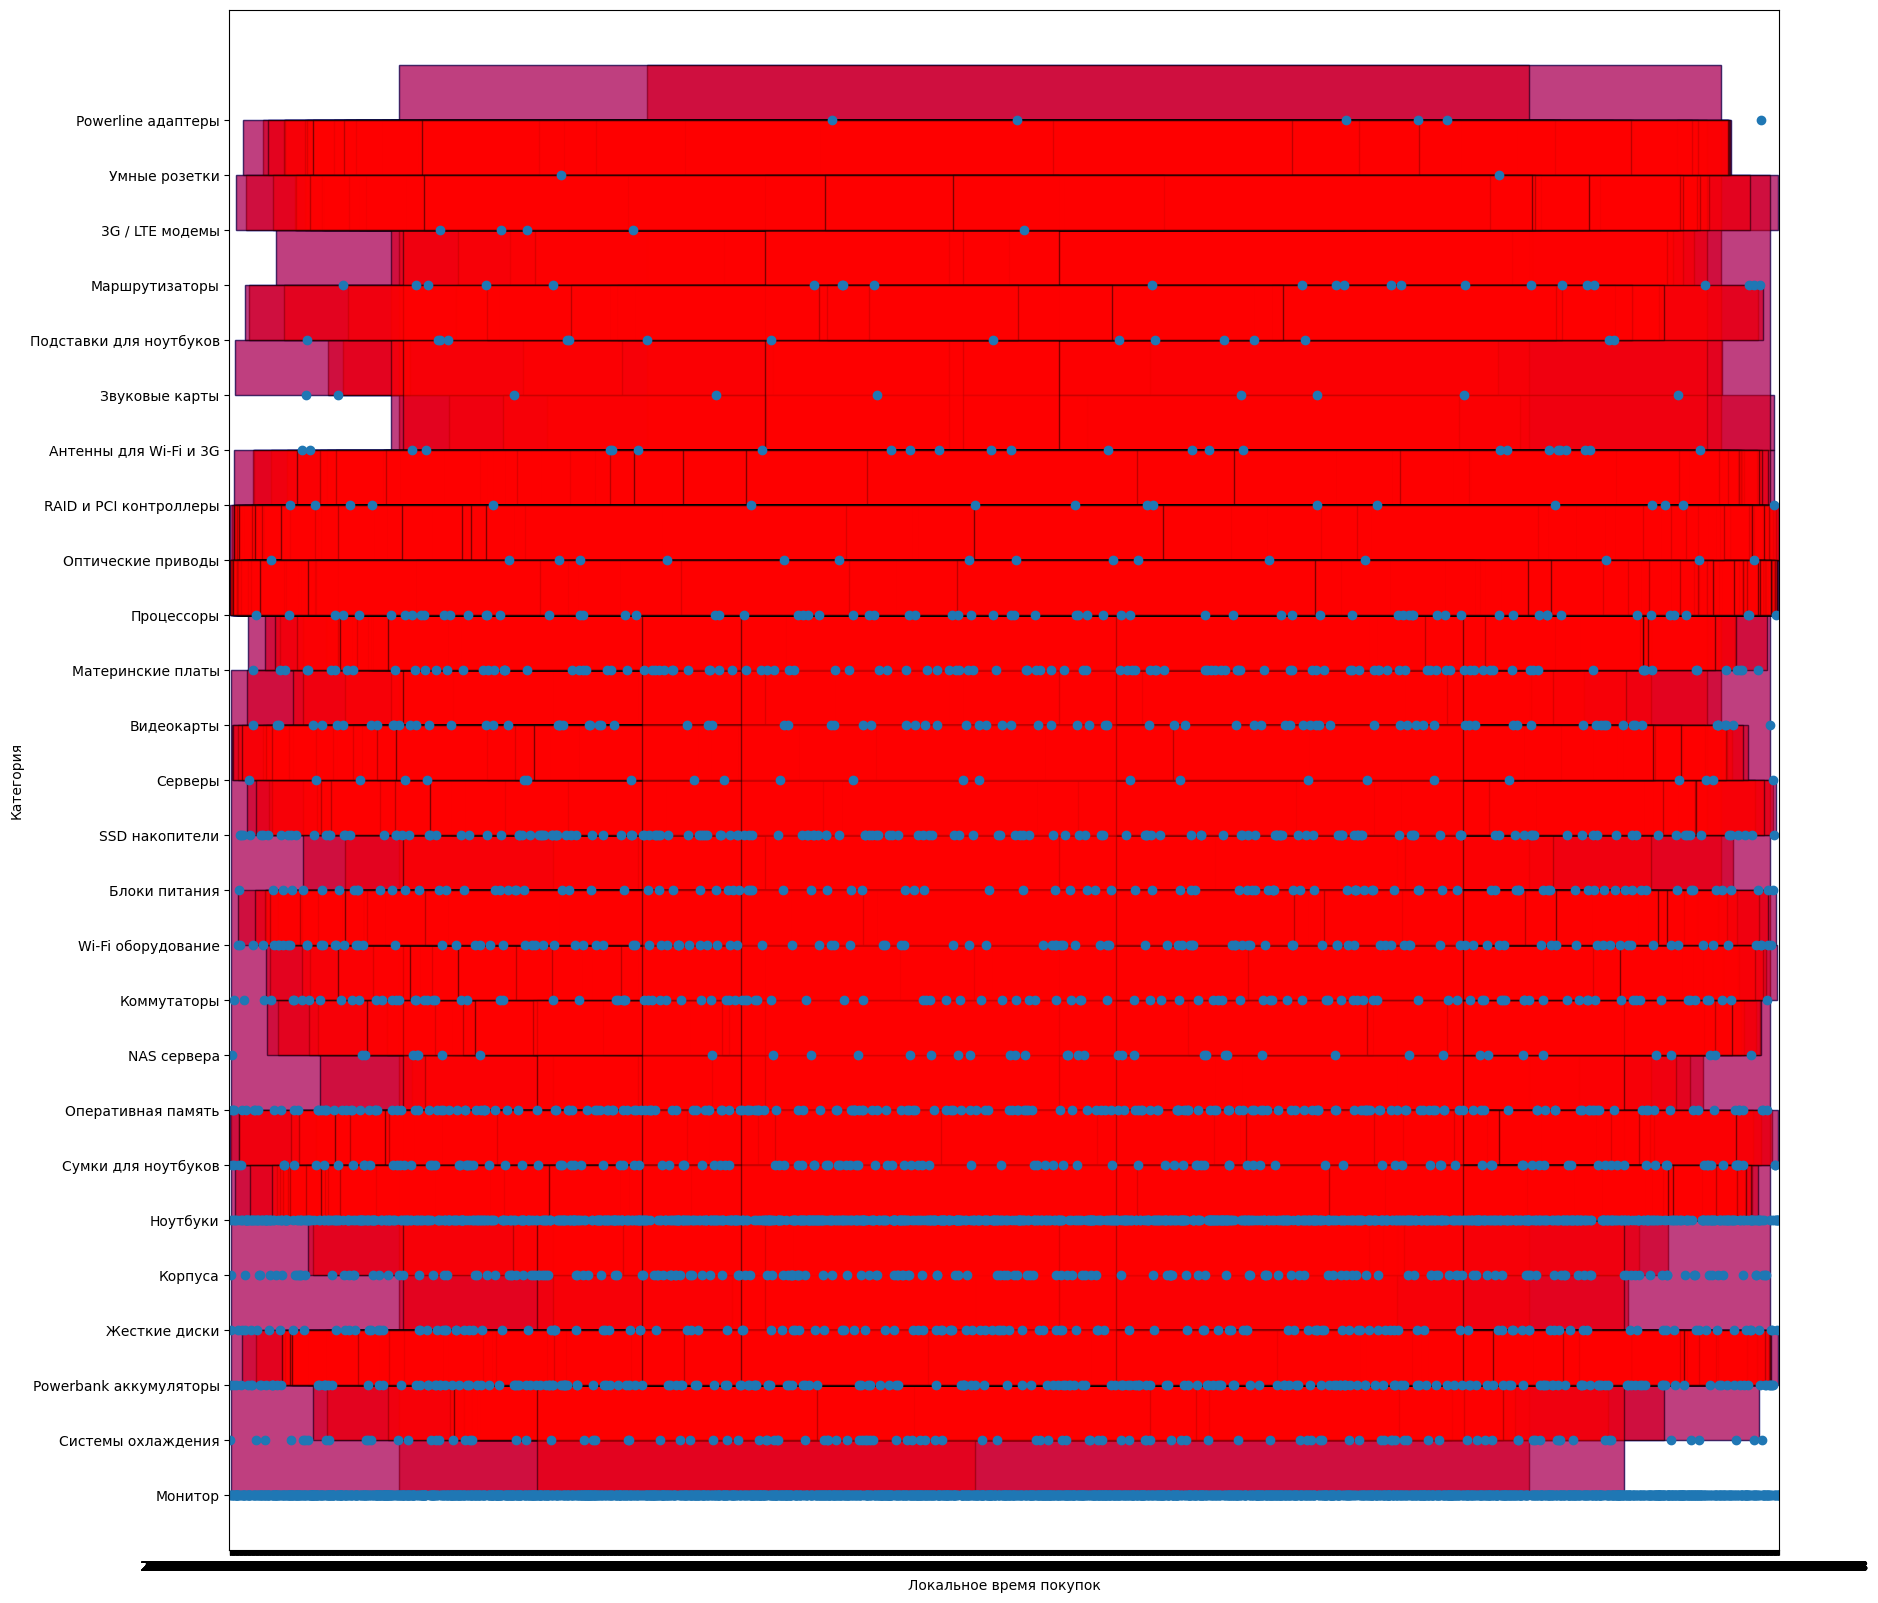

In [28]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, l_diverse_rects, column_x, column_y, edgecolor='b', facecolor='b')
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

### 3.3 Обезличивание набора

<p align="justify"> $\qquad$ На основании проведенной выше кластеризации проведем обезличивание методом обобщения, как и раньше, используя функцию build_animized_dataset (см. 2.5.1)</p>

In [29]:
# разбиваем набор с учетом l-diverse кластеров
dfl = build_anonymized_dataset(df, finished_l_diverse_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...
Finished 601 partitions...
Finished 701 partitions...
Finished 801 partitions...
Finished 901 partitions...
Finished 1001 partitions...
Finished 1101 partitions...
Finished 1201 partitions...
Finished 1301 partitions...
Finished 1401 partitions...
Finished 1501 partitions...


In [30]:
# Выводим сэмпл
dfl.head

<bound method NDFrame.head of                                 Локальное время покупок  \
0     [2020-01-19T21:07+00:03,2020-03-08T00:08+00:03...   
1     [2020-01-19T21:07+00:03,2020-03-08T00:08+00:03...   
2     [2020-01-26T14:43+00:03,2020-01-26T06:33+00:03...   
3     [2020-01-26T14:43+00:03,2020-01-26T06:33+00:03...   
4     [2020-01-26T14:43+00:03,2020-01-26T06:33+00:03...   
...                                                 ...   
4428  [2020-02-13T20:09+00:03,2020-02-20T03:04+00:03...   
4429  [2020-02-13T20:09+00:03,2020-02-20T03:04+00:03...   
4430  [2020-02-13T20:09+00:03,2020-02-20T03:04+00:03...   
4431  [2020-02-08T14:38+00:03,2020-02-18T17:22+00:03...   
4432  [2020-02-08T14:38+00:03,2020-02-18T17:22+00:03...   

                           Категория                       Бренды  \
0     [Умные розетки,Звуковые карты]            [Asus,Elgato,RME]   
1     [Умные розетки,Звуковые карты]            [Asus,Elgato,RME]   
2                          [Серверы]  [Hewlett Packard

In [31]:
# Осуществляем окончательную сортировку  для набора с  l-diversity кластеризацией
dfl.sort_values([sensitive_column])

,Локальное время покупок,Категория,Бренды,Кол-во покупок,count
0,"[2020-01-19T21:07+00:03,2020-03-08T00:08+00:03...","[Умные розетки,Звуковые карты]","[Asus,Elgato,RME]",1,4
1189,"[2020-02-25T20:28+00:03,2020-03-02T18:58+00:03...",[Корпуса],"[Crown,Be quiet]",1,1
3225,"[2020-01-01T06:34+00:03,2020-01-22T16:09+00:03...",[Ноутбуки],[HP],1,2
3230,"[2020-01-06T17:58+00:03,2020-01-20T02:34+00:03...",[Ноутбуки],[HP],1,1
3234,"[2020-01-13T17:53+00:03,2020-03-08T08:05+00:03...",[Ноутбуки],[HP],1,2
...,...,...,...,...,...
2663,"[2020-02-22T16:43+00:03,2020-01-17T03:11+00:03...",[Монитор],[Acer],5,1
642,"[2020-01-31T12:29+00:03,2020-01-27T22:34+00:03...",[Сумки для ноутбуков],[Case Logic],5,1
3807,"[2020-02-01T04:36+00:03,2020-02-08T05:19+00:03...",[Монитор],[Dell],5,2
2670,"[2020-01-31T21:59+00:03,2020-01-20T18:13+00:03...",[Монитор],[AOC],5,1


# 4 РАСЧЕТ НА ОСНОВЕ $t$-CLOSENESS

<p align="justify"> $\qquad$ Рассмотренный выше метод с кластеризацией по $l$-diversity создает кластеры с большим количеством записей для одного значения чувствительного атрибута, так что безопасность данных страдает в случае если имеются догадки о принадлежности того или иного человека к данному кластеру.</p>

<p align="justify"> $\qquad$ В противовес этому метрика $t$-closeness добивается такой кластеризации, что внутри кластера значения чувствительного атрибута распределяются также как во всем наборе.</p>

### 4.1 Валидация $t$-closeness

<p align="justify"> $\qquad$ Изменения функции, реализованной для $k$-anonimity  - `is_valid` (см. 2.2), направлены на учет разнообразия чувствительного атрибута внутри кластера в сравнении с распределением по всему набору. В случае удачи возвращается `True` иначе `False`. Измерение разнообразия осуществляется через метрику Колмогорова-Смирнова (`Kolmogorov-Smirnov`), дающее максимальное расстояние между двумя распределениями. В данном случае рассчитывается расстояние между эмпирическими распределениями вероятности чувствительного атрибута по всему кластеру по сравнению с распределением по кластеру.</p>
<p align="justify"> $\qquad$ В качестве чувствительного атрибута могут выступать как чисенные, таки и категориальные данные</p>

In [32]:
# расчет распределения на всем наборе для чувствительного набора 
global_freqs = {}
total_count = float(len(df))
group_counts = df.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    global_freqs[value] = p

In [33]:
global_freqs

{1: 0.19866666666666666,
 2: 0.20033333333333334,
 3: 0.18883333333333333,
 4: 0.2125,
 5: 0.19966666666666666}

In [34]:
# Основная функция для валидации t-closeness
def t_closeness(df, partition, column, global_freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = df.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, global_freqs, p=0.2):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param     global_freqs: The global frequencies of the sensitive attribute values
    :param                p: The maximum allowed Kolmogorov-Smirnov distance
    """
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, global_freqs) <= p

### 4.2 Кластеризация по $t$-closeness

Здесь используем функцию partition_dataset с учетом дополнительного условия по t-closeness

In [35]:
# Let's apply this to our dataset
finished_t_close_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_t_close(*args, global_freqs))

In [36]:
len(finished_t_close_partitions)

461

### 4.3 Обезличивание набора
<p align="justify"> $\qquad$ Обезличивание проводим на основе метода обобщения ранее использованной функцией `build_anonymized_dataset`:</p>

In [37]:
dft = build_anonymized_dataset(df, finished_t_close_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...


In [38]:
# Сортируем набор по чувствительному атрибуту
dft.sort_values([sensitive_column])

,Локальное время покупок,Категория,Бренды,Кол-во покупок,count
0,"[2020-02-21T06:41+00:03,2020-02-26T00:38+00:03...","[Звуковые карты,Маршрутизаторы,Антенны для Wi-...","[Trust,Cisco,ZyXel,MikroTik,Asus,Rubetek,D-Lin...",1,14
425,"[2020-02-21T12:20+00:03,2020-02-26T20:55+00:03...","[Wi-Fi оборудование,RAID и PCI контроллеры]","[TP-LINK,EnGenius,STLab]",1,2
1299,"[2020-01-29T05:21+00:03,2020-01-08T10:03+00:03...",[Монитор],[Dell],1,3
1304,"[2020-02-23T11:39+00:03,2020-02-06T07:11+00:03...",[Монитор],"[Viewsonic,Asus,LG]",1,3
420,"[2020-02-08T18:19+00:03,2020-02-26T23:23+00:03...","[Wi-Fi оборудование,RAID и PCI контроллеры]","[TP-LINK,Cisco,STLab,EnGenius]",1,3
...,...,...,...,...,...
155,"[2020-01-23T03:12+00:03,2020-02-14T14:17+00:03...",[Коммутаторы],"[HP,D-Link,TP-LINK,Tenda,ZyXel,Cisco,Allied Te...",5,15
395,"[2020-02-21T11:07+00:03,2020-01-10T21:13+00:03...",[Блоки питания],"[Thermaltake,Gigabyte,Sea Sonic,ExeGate]",5,1
1838,"[2020-01-21T07:02+00:03,2020-02-08T05:50+00:03...",[Монитор],"[Acer,LG]",5,7
150,"[2020-02-13T19:22+00:03,2020-02-25T08:45+00:03...",[Оптические приводы],"[HP,Dell,Apple,LG,Asus]",5,1


### 4.4 Визуализация обезличенного набора

<p align="justify"> $\qquad$ Рассчитаем граница полученных кластеров/классов эквивалентности с использованием функции get_partition_rects:

In [39]:
column_x, column_y = feature_columns[:2]
t_close_rects = get_partition_rects(df, finished_t_close_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

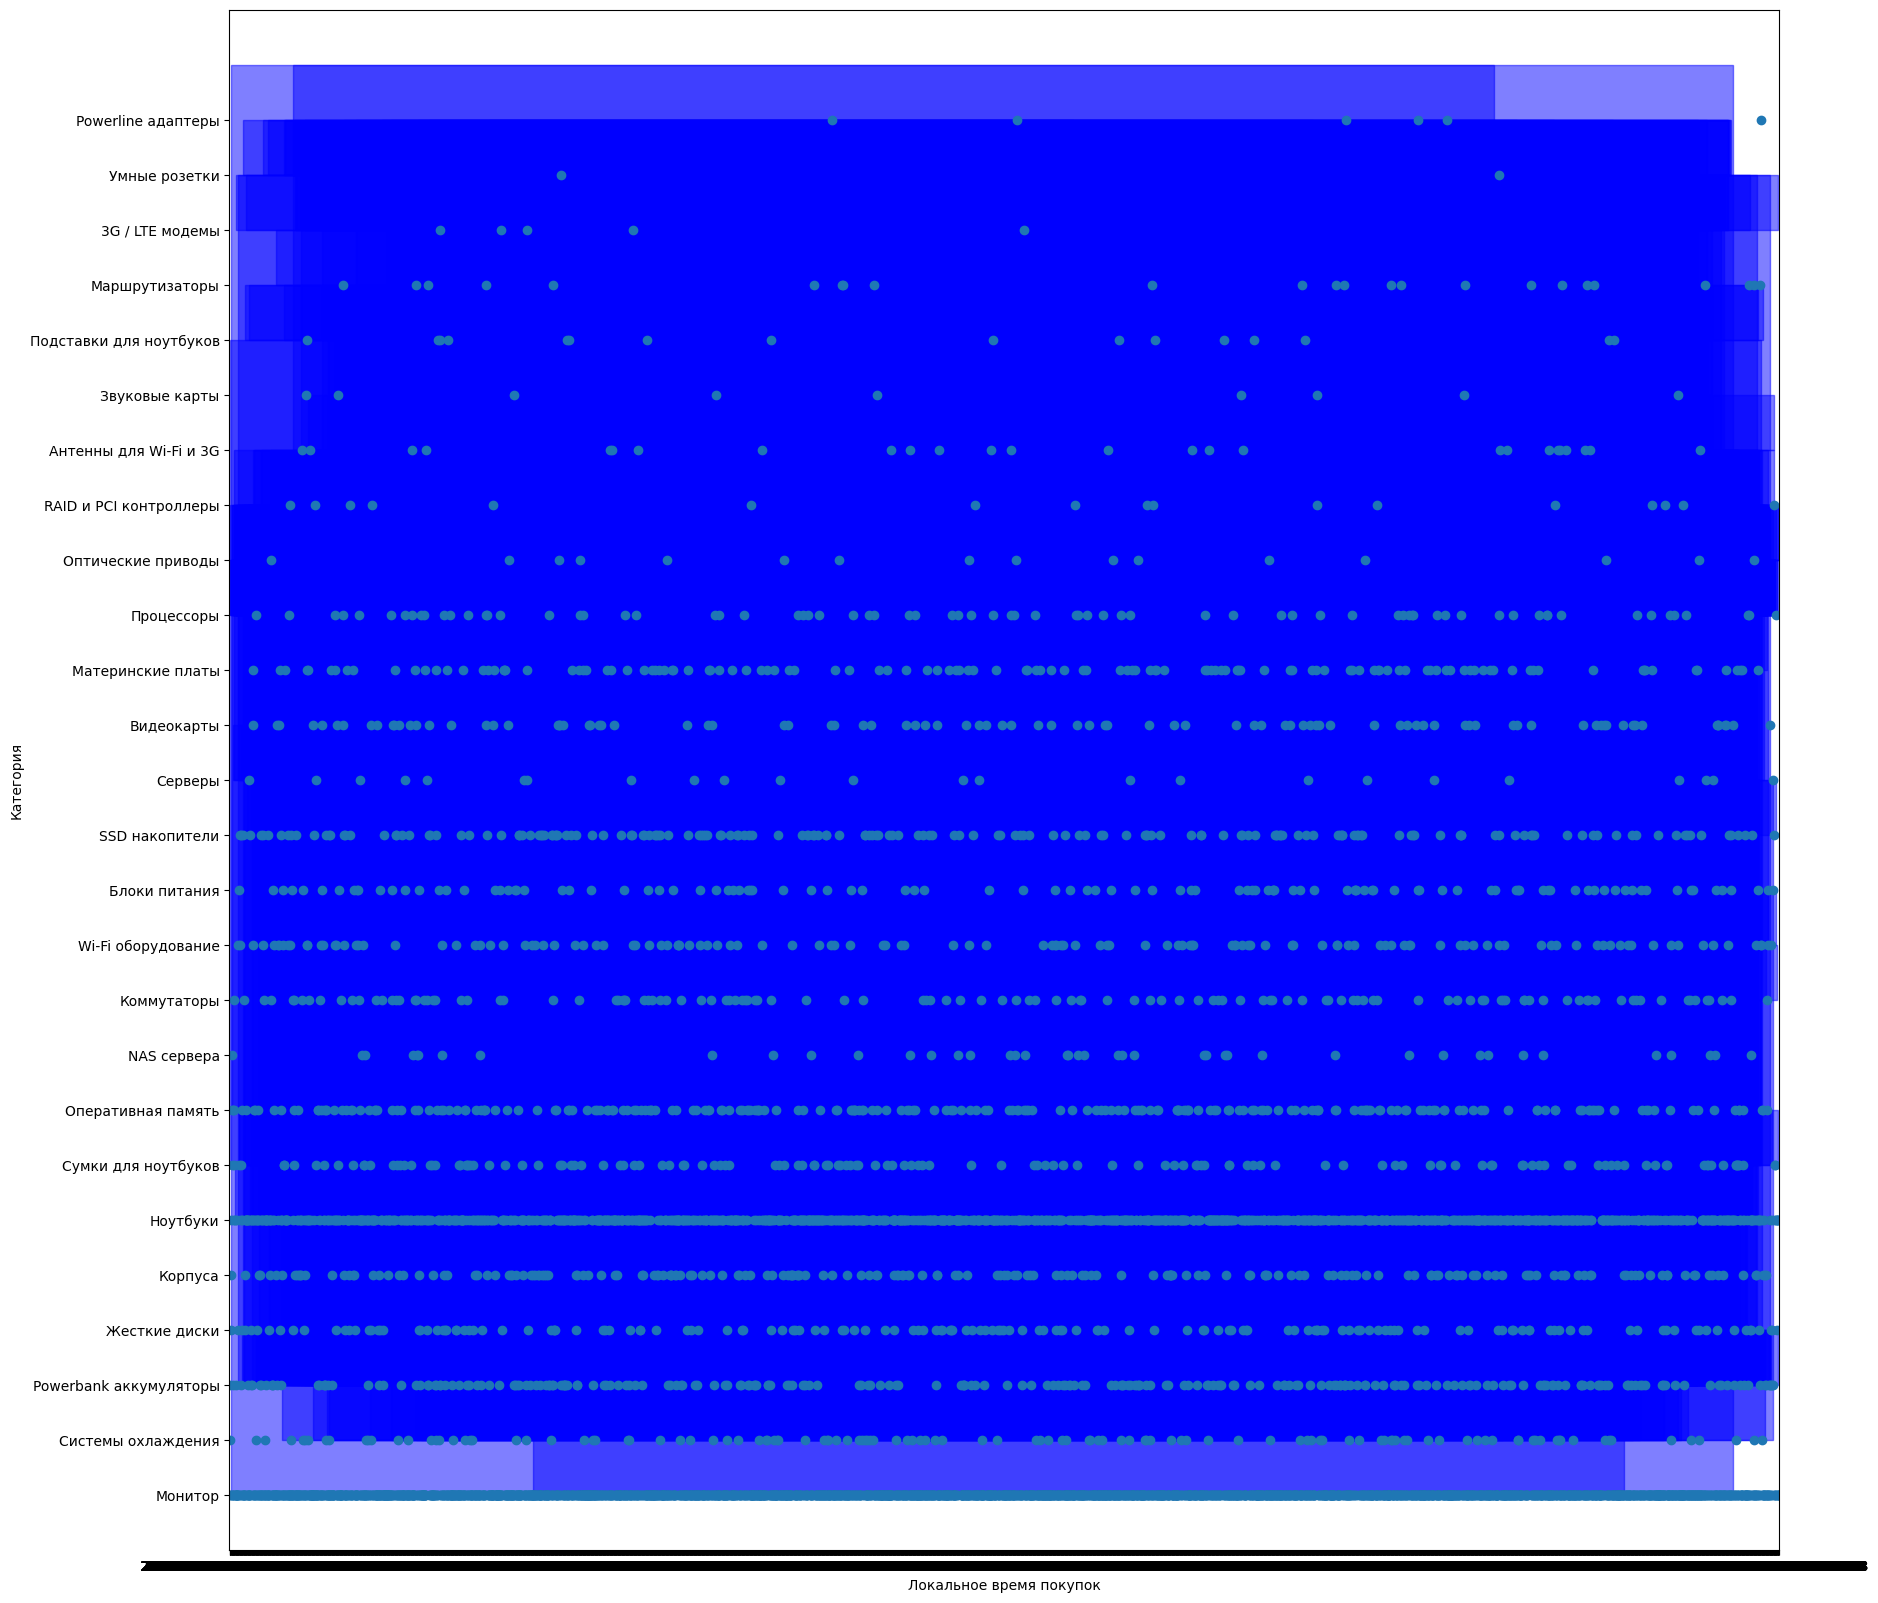

In [40]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, t_close_rects, column_x, column_y, edgecolor='b', facecolor='b')
pl.scatter(df[column_x], df[column_y])
pl.show()

# 5 ОСНОВНЫЕ ВЫВОДЫ

<p align="justify"> $\qquad$ В данном ноутбуке представлены методы обезличивания данных с учетом метрик $k$-anonimity, $l$-diversity и $t$-closeness. в основе всех методов лежит алгоритм кластеризации Мондриана с различными критериями, контролирующими границы кластеров. После осуществления кластеризации дальнейшее обезличивание проводится за счет методов обобщения (<i>generalization</i>). Метод может быть доработан за счет применения других техник обезличивания, а также улучшения обработки кластеров </p>